In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Let's assume our data is generated according to

$$x_{i, k} \sim \text{Poiss}\left(\sum_{d=1}^D z_{i,d}\theta_{d,k}\right) i=1,\dots,N,\; k=1,\dots, K$$

where $D=2, K=16$, and where the true $\theta$ and $x$ are as follows:

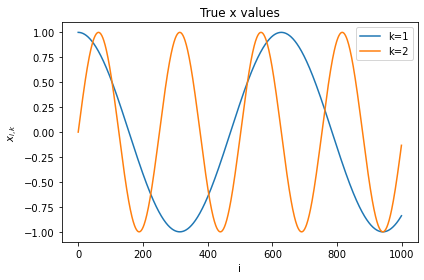

In [2]:
t = np.linspace(0, 10, 1000)
true_z = np.zeros((1000, 2))
true_z[:, 0] = np.cos(t)
true_z[:, 1] = np.sin(t*2.5)

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(true_z[:, 0], label='k=1')
ax.plot(true_z[:, 1], label='k=2')
ax.set_xlabel('i')
ax.set_ylabel(r'$x_{i,k}$')
ax.legend()
ax.set_title('True x values')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

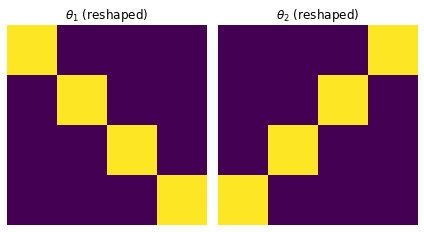

In [3]:
true_theta = 2*np.array([[1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1], [0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0]]) + 0.1

fig, ax = plt.subplots(1, 2, figsize=(6, 4), tight_layout=True)
ax[0].imshow(true_theta[0, :].reshape(4,4))
ax[0].axis('off')
ax[0].set_title(r'$\theta_1$ (reshaped)')
ax[1].imshow(true_theta[1, :].reshape(4,4))
ax[1].axis('off')
ax[1].set_title(r'$\theta_2$ (reshaped)')
plt.show

## Note that $\theta_1, \theta_2$ are vectors, that can be reshaped to give the images above

true rates for 10 time points


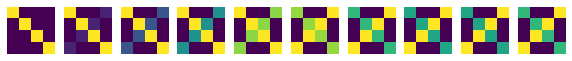

reshaped observations for 10 time points


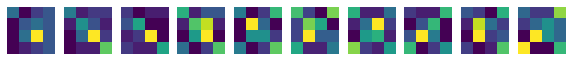

In [5]:
true_rate = np.exp(np.dot(true_z, true_theta))
print('true rates for 10 time points')
fig, ax = plt.subplots(1,10, figsize=(10,10))
for i in range(10):
    ax[i].imshow(true_rate[i*10,:].reshape(4,4))
    ax[i].axis('off')
plt.show()

print('reshaped observations for 10 time points')
x = np.random.poisson(true_rate)
fig, ax = plt.subplots(1,10, figsize=(10,10))
for i in range(10):
    ax[i].imshow(x[i*10,:].reshape(4,4))
    ax[i].axis('off')
plt.show()

# Let's assume the following parametric model $p_\theta(z, x)$

$$\begin{aligned}
z_{i, d} \sim& N(0, 1) & i=1,\dots,N,\; d=1,\dots, D\\
\theta_{k, d} \sim& N(0, 1) & k=1,\dots,K,\; d=1,\dots, D\\
x_{i, k} \sim& \text{Poiss}\left(\sum_d z_{i,d}\theta_{d,k}\right)& i=1,\dots,N,\; k=1,\dots, K\\\end{aligned}$$


# We will use an MLP to model our $q_\phi(z|x)$

$$q_\phi(z|x) = N\left(\mu_\phi(x), \sigma^2_\phi(x)\right)$$


We can use the reparametrization trick to sample $z^{(i,\ell)}\sim q_\phi(z|x^{(i)})$:
$$\begin{aligned}
\epsilon^{(\ell)} \sim& N\left(0, \mathbb{I}_D\right)\\
z^{(i,\ell)} =& \mu_\phi(x^{(i)}) + \sigma_\phi(x^{(i)})\odot\epsilon\end{aligned}$$




In [12]:
import pdb
class Poisson_AEVB(nn.Module):

    def __init__(self):
        super(Poisson_AEVB, self).__init__()
        # Setting up the parameters for q_phi
        
        self.fc1 = nn.Linear(16, 8) # fully connected NN, 16-dim input, 8-dim output
        self.fc1_bn=nn.BatchNorm1d(8) # batch norm layer for stability
        self.fc_mu = nn.Linear(8, 2) # fully connected NN, 8-dim input, 2-dim output
        self.fc_sigma = nn.Linear(8, 2) # fully connected NN, 8-dim input, 2-dim output
        
        # parameters to be optimized
        self.log_theta = torch.randn((2,16))
        # re-scale to avoid blowing up due to the exp
        self.log_theta/= torch.exp(torch.linalg.norm(torch.tensor(self.log_theta), axis=0))
        self.log_theta = torch.nn.Parameter(self.log_theta) 
        
    def forward(self, x):
        # calculate mu(x), sigma(x); sampling z and calculating rate.
        x = F.relu(self.fc1_bn(self.fc1(x)))
        mu = self.fc_mu(x)
        log_var = self.fc_sigma(x)
        sigma = torch.exp(log_var / 2)
        
        noise = torch.randn_like(sigma)
        z = mu + noise * sigma # just using L=1 for now
        rate = torch.exp(torch.matmul(z, self.log_theta))
        
        return mu, sigma, rate

    def elbo_loss(self, x, mu, sigma, rate):
    
        q_loss = -0.5 * torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2, 1) 
    
        p_loss = torch.sum(rate - x*torch.log(rate), 1) # log likelihood under q
    
        theta_loss = torch.sum(0.5*self.log_theta**2) # MAP regularizer for theta
        return torch.sum(p_loss + q_loss) + theta_loss
    


In [13]:
x_torch = torch.Tensor(x)
model = Poisson_AEVB()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10000):
    optimizer.zero_grad()
    mu, sigma, rate = model(x_torch)
    
    loss = model.elbo_loss(x_torch, mu, sigma, rate)
    if torch.isnan(loss): # break out if we end up with numerical instabilities
        print('Oh no!! Numeric instabilities. Try again')
    loss.backward()
    optimizer.step()
    if epoch%1000== 0:
        print(loss.item())

/var/folders/2s/3mnfvpbd2f9bdrm1t5h7zs8c0000gn/T/ipykernel_77162/877578069.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_theta/= torch.exp(torch.linalg.norm(torch.tensor(self.log_theta), axis=0))


16651.51171875
11796.623046875
7692.1015625
6423.95751953125
5553.765625
4629.00244140625
3686.817138671875
2962.4833984375
2331.02197265625
2087.098876953125
1948.0076904296875
1787.4296875
1627.9739990234375
1616.59716796875
1526.672607421875
1478.32421875
1403.4140625
1418.5743408203125
1412.34619140625
1402.028564453125
1359.8936767578125
1273.090576171875
1353.9232177734375
1330.461669921875
1301.4072265625
1230.22216796875
1270.250244140625
1118.1375732421875
1156.7906494140625
1177.336669921875
1198.77587890625
1138.3868408203125
1118.3878173828125
1123.9473876953125
1167.9404296875
1141.7779541015625
1131.0401611328125
1188.2027587890625
1145.431396484375
1115.5806884765625
1122.9127197265625
1127.5791015625
1132.4044189453125
1104.361328125
1178.902587890625
1163.1373291015625
1032.3255615234375
1091.759765625
1083.458740234375
1085.0562744140625
1104.4490966796875
1033.742431640625
1070.718994140625
1009.1865234375
1067.4996337890625
1045.2462158203125
1116.678466796875
1133.

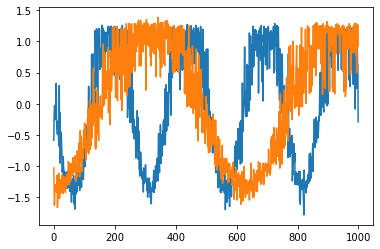

In [14]:
plt.plot(mu.detach().numpy())
plt.show()

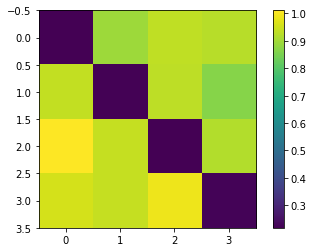

In [16]:
plt.imshow(torch.exp(model.log_theta[1]).detach().numpy().reshape(4,4))
plt.colorbar()

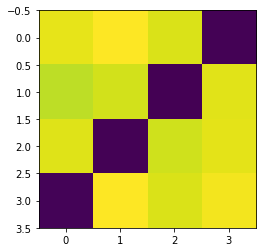

In [17]:
plt.imshow(torch.exp(model.log_theta[0]).detach().numpy().reshape(4,4))